# Evaluation vorticity 8x -> 2.2km
## Diff model

**Cleaned code version**

Vorticity transform: standardize (based on train set mean and std) then devide by standardized train set max

Target transform: sqrt then divide by sqrted train set max

Sample inverse transform: multiply by train set max, clip negative values to 0 then square

In [1]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree

In [2]:
split = "val"
dataset_name = "2.2km-coarsened-8x_london_vorticity850_random"

In [23]:
run_name = "2.2km-coarsened-8x_london_vorticity850_random-transform-data-cleancode"
checkpoint_id = 100

pred_ds = xr.open_mfdataset(os.path.join(os.getenv("DERIVED_DATA"), 'score-sde/workdirs/subvpsde/xarray_cncsnpp_continuous', run_name, f'samples/checkpoint-{checkpoint_id}', split, 'predictions-*.nc')).isel(grid_latitude=slice(32), grid_longitude=slice(32))
eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, f"{split}.nc")).isel(grid_latitude=slice(32), grid_longitude=slice(32))
train_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, f"train.nc")).isel(grid_latitude=slice(32), grid_longitude=slice(32))

# convert from kg m-2 s-1 (i.e. mm s-1) to mm day-1
pred_ds["pred_pr"] = (pred_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
eval_ds["target_pr"] = (eval_ds["target_pr"]*3600*24).assign_attrs({"units": "mm day-1"})
train_ds["target_pr"] = (train_ds["target_pr"]*3600*24).assign_attrs({"units": "mm day-1"})

merged_ds = xr.merge([pred_ds, eval_ds])#, join="inner")

In [5]:
merged_ds

<xarray.Dataset>
Dimensions:                     (time: 4320, sample_id: 10, bnds: 2,
                                 grid_latitude: 32, grid_longitude: 32)
Coordinates:
  * time                        (time) object 1980-12-03 12:00:00 ... 2080-11...
    forecast_period             (time) timedelta64[ns] 452 days 12:00:00 ... ...
    forecast_reference_time     (time) object 1979-09-01 00:00:00 ... 2059-09...
    realization                 (time) int32 1100000 1100000 ... 1100000 1100000
    pressure                    (time) float32 850.0 850.0 850.0 ... 850.0 850.0
    season                      (time) int64 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * grid_latitude               (grid_latitude) float32 -1.58 -1.56 ... -0.9599
  * grid_longitude              (grid_longitude) float32 360.9 360.9 ... 361.5
  * sample_id                   (sample_id) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: bnds
Data variables:
    rotated_latitude_longitude  (sample_id, time) float64 -2.147e+09 ... -2.1...
    time_bnds                   (sample_id, time, bnds) object 1980-12-03 00:...
    grid_latitude_bnds          (sample_id, time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (sample_id, time, grid_longitude, bnds) float32 ...
    forecast_period_bnds        (sample_id, time, bnds) float64 1.085e+04 ......
    pred_pr                     (sample_id, time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 4320, 32, 32), meta=np.ndarray>
    target_pr                   (time, grid_latitude, grid_longitude) float32 ...
    vorticity850                (time, grid_latitude, grid_longitude) float64 ...

In [6]:
pred_pr = merged_ds["pred_pr"]
target_pr = merged_ds["target_pr"]

total_pred_pr = merged_ds["pred_pr"].sum(dim=["grid_longitude", "grid_latitude"])
total_target_pr = merged_ds["target_pr"].sum(dim=["grid_longitude", "grid_latitude"])

## Samples

In [7]:
sorted_time = merged_ds.sum(dim=['grid_latitude', 'grid_longitude']).sortby('target_pr')["time"].values

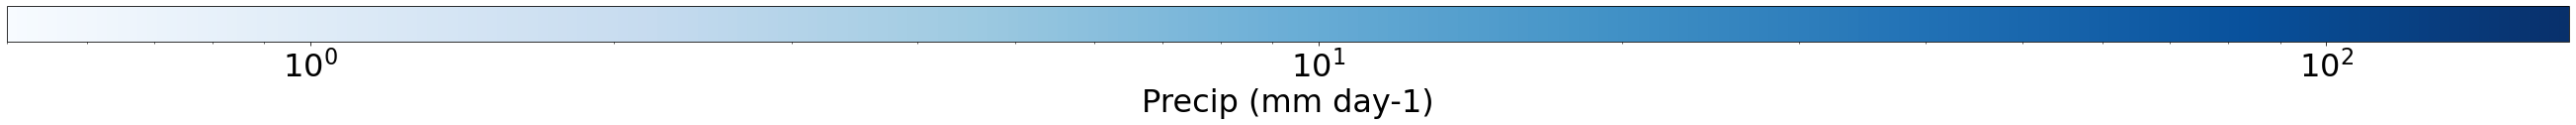

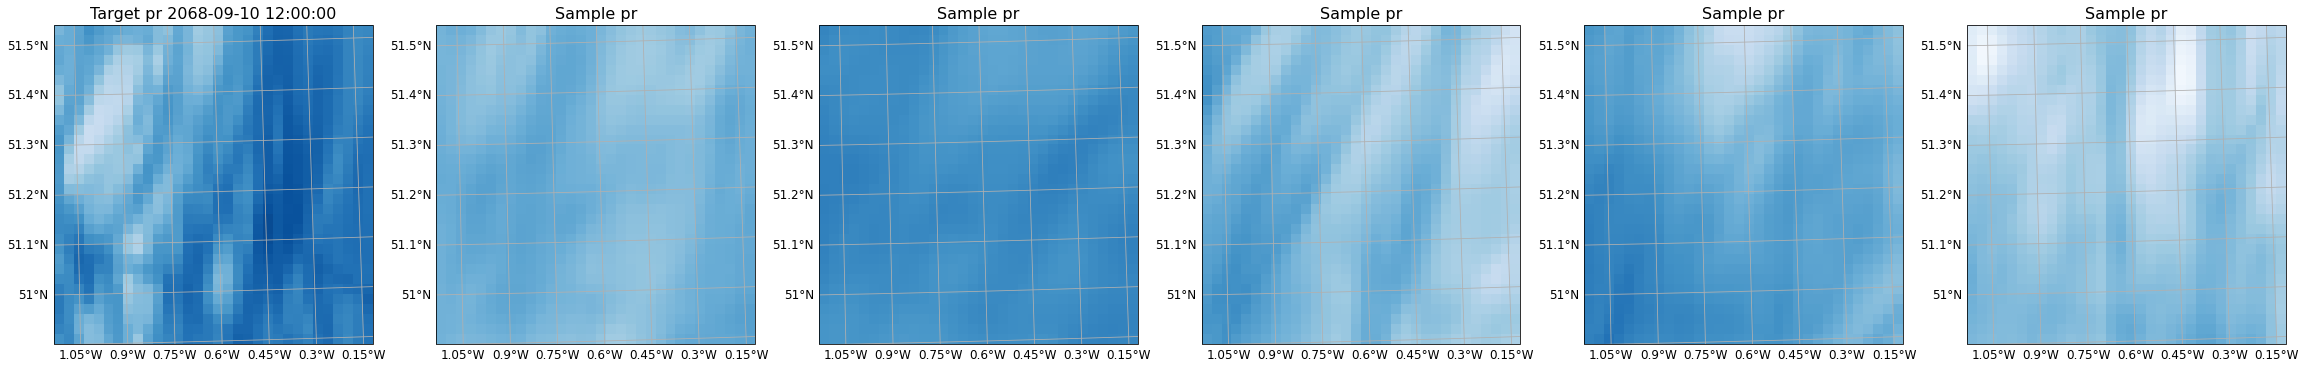

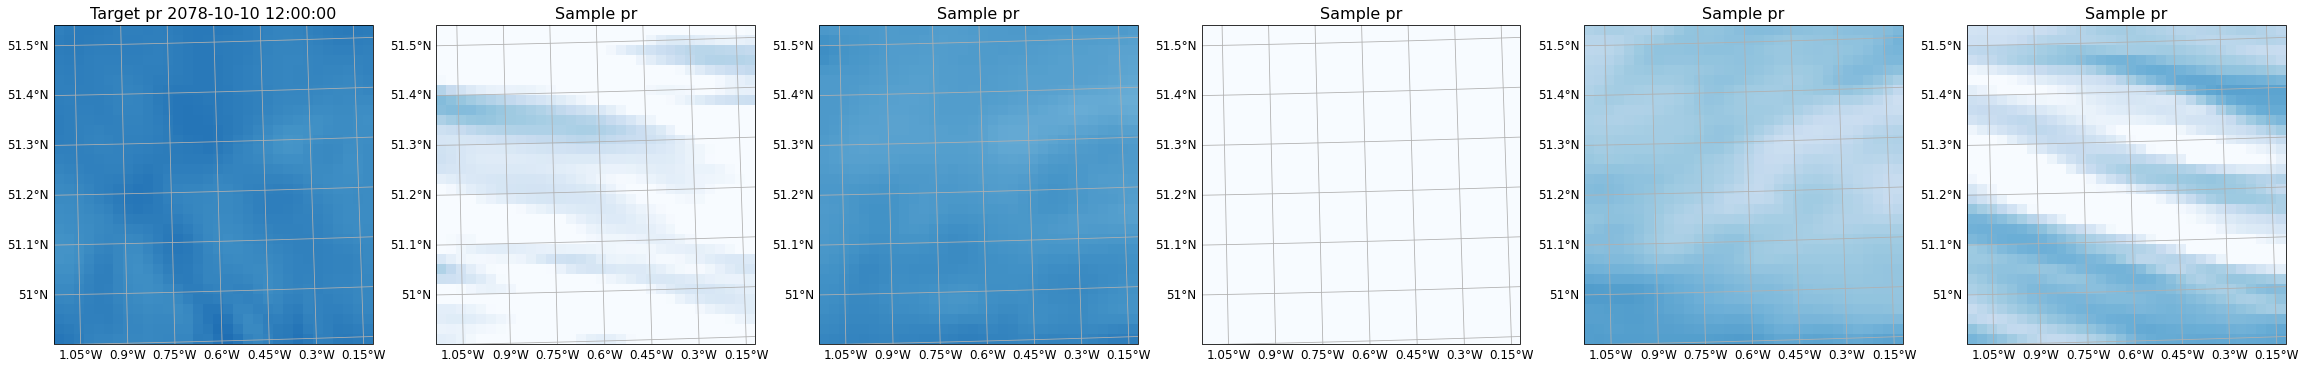

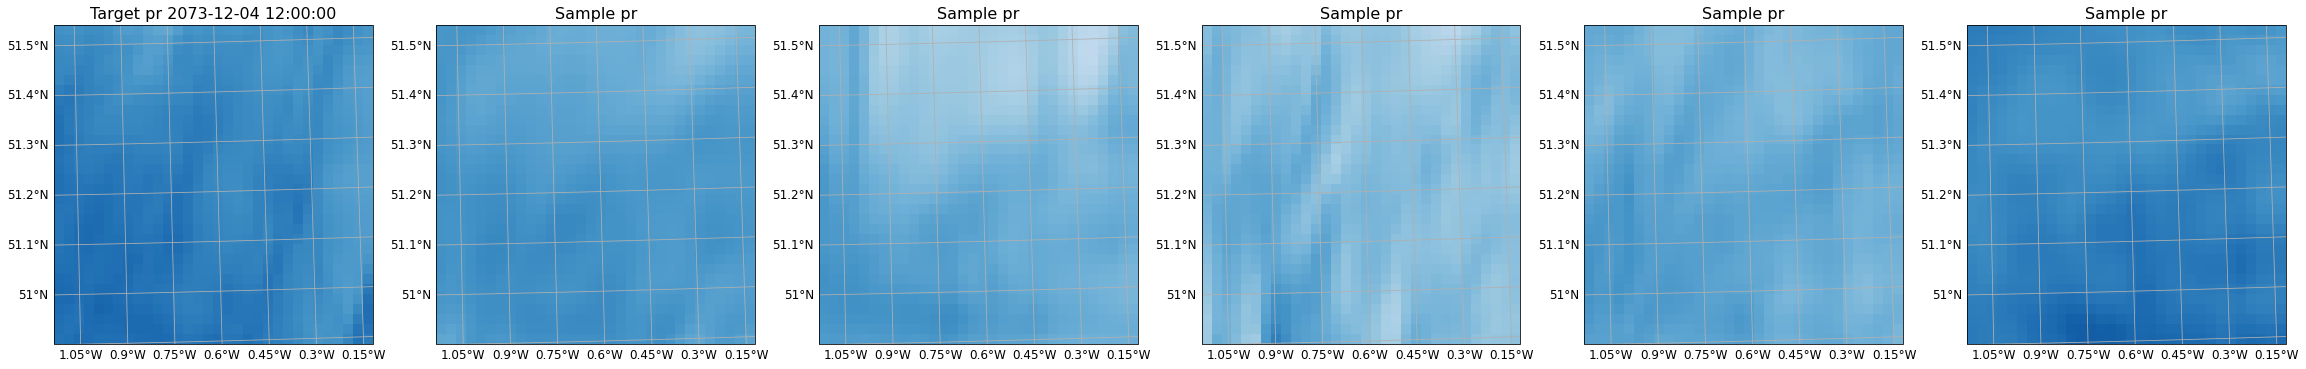

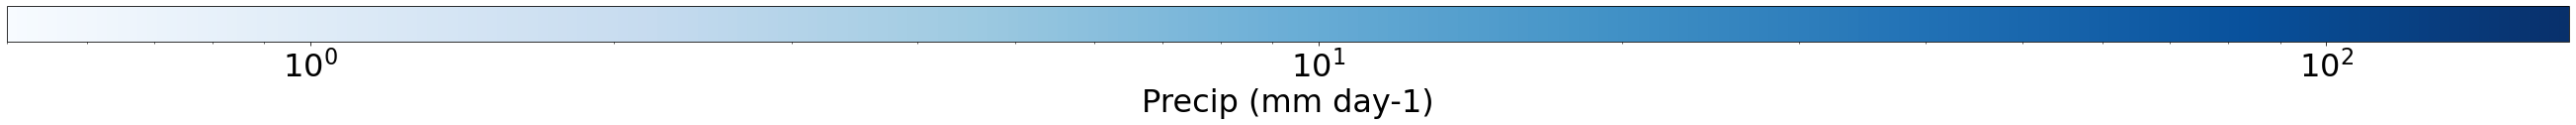

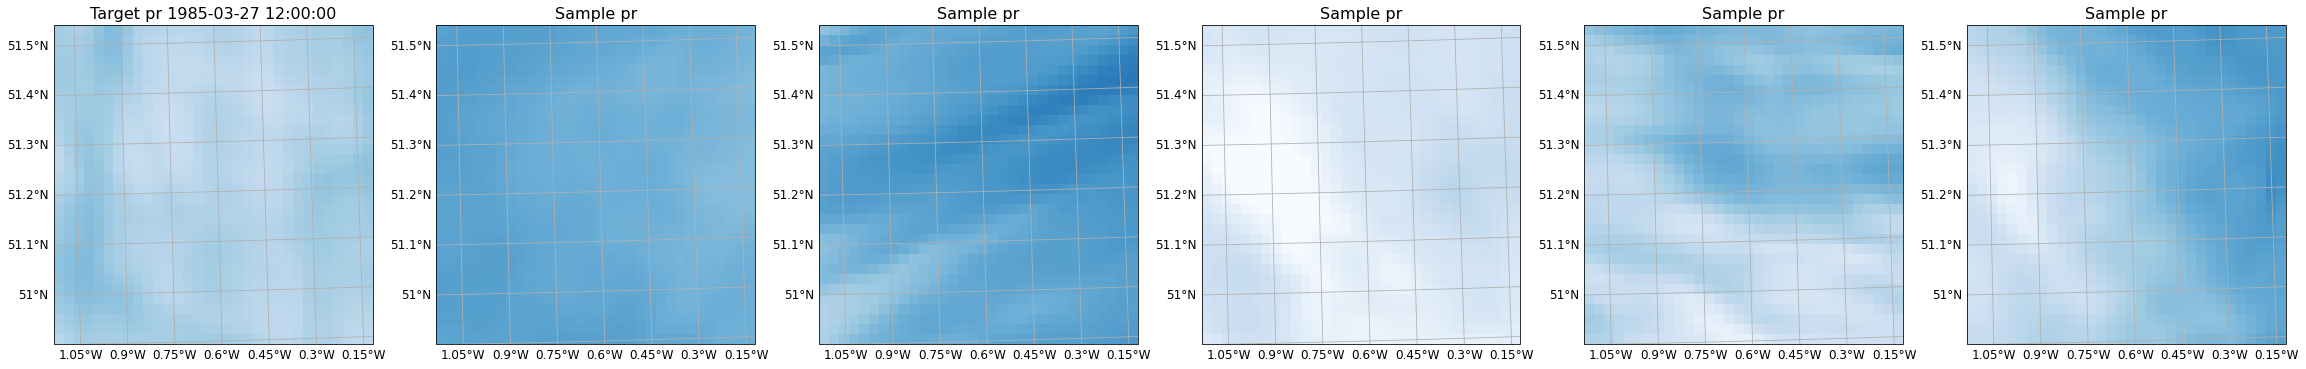

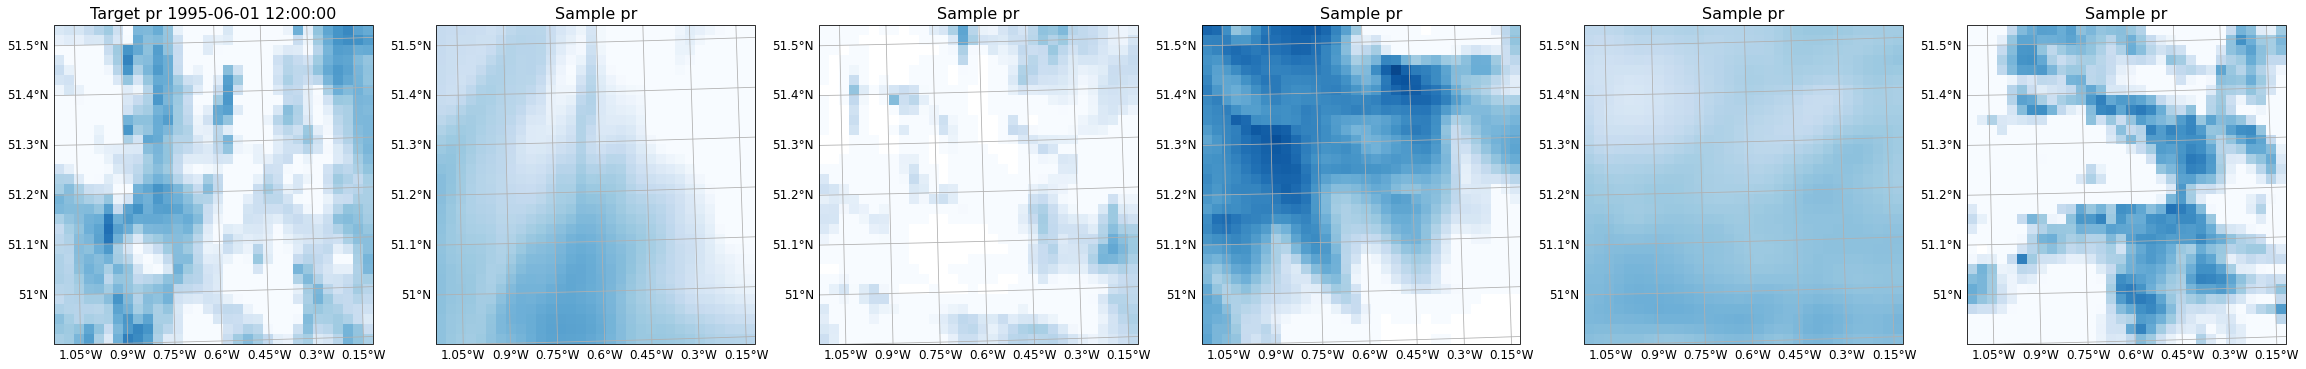

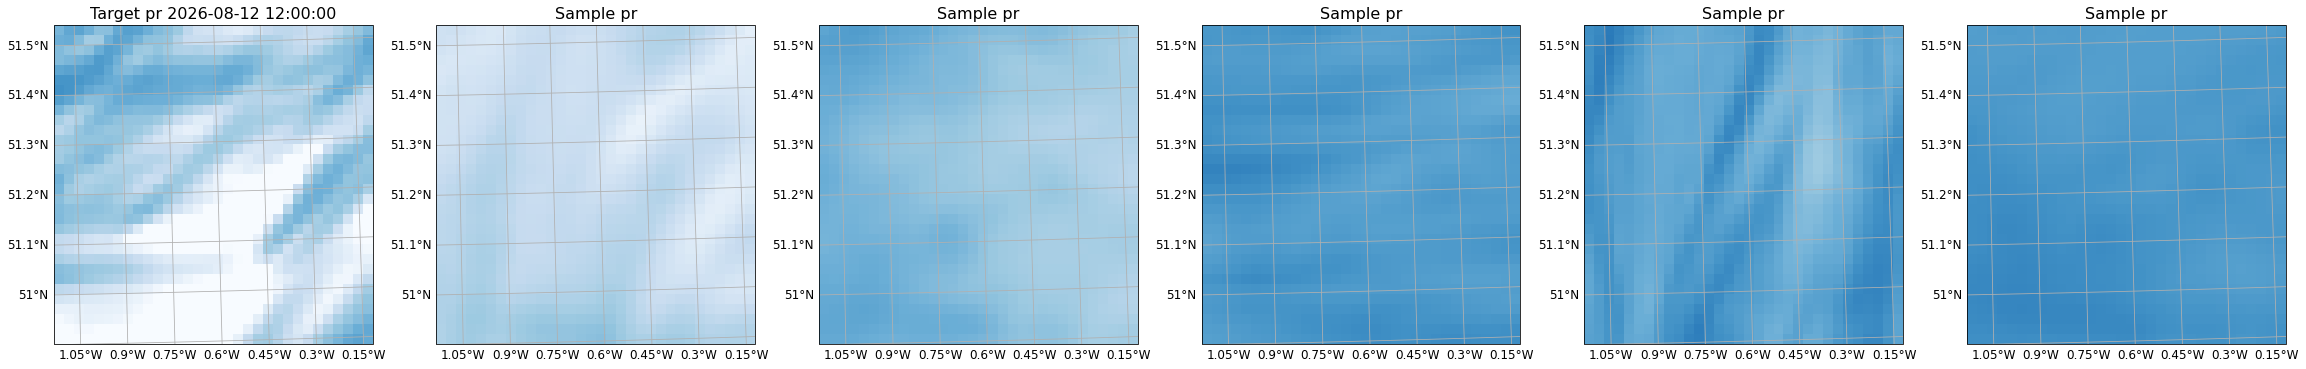

In [63]:
def plot_pr(da, ax, title="", norm=matplotlib.colors.LogNorm(), cmap='Blues', add_colorbar=False, **kwargs):#vmin=None, vmax=None, add_colorbar=False, cmap='Blues'):
    da.plot(ax=ax, norm=norm, add_colorbar=add_colorbar, cmap=cmap, **kwargs)
    # da.plot(ax=ax, add_colorbar=True, cmap=cmap)
    ax.set_title(title, fontsize=16)
    ax.coastlines()
    ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, x_inline=False, y_inline=False, xlabel_style=dict(fontsize=12), ylabel_style=dict(fontsize=12))
    
def show_predictions(ds, timestamps, vmin, vmax):
    num_predictions = 5#len(ds["sample_id"])
    
    num_plots_per_ts = num_predictions+1 # plot each sample and true target pr
    
    for (i, ts) in enumerate(timestamps):
        if i % 3 == 0:
            # s_m = matplotlib.cm.ScalarMappable(cmap="Blues", norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
            fig = plt.figure(figsize=(40, 5))
            ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
            cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', cmap='Blues', norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
            ax.set_xlabel("Precip (mm day-1)", fontsize=32)
            ax.tick_params(axis='both', which='major', labelsize=32)
            plt.show()
        fig, axes = plt.subplots(1, num_plots_per_ts, figsize=(40,40), subplot_kw={'projection': cp_model_rotated_pole})
        
        ax = axes[0]
        plot_pr(ds.sel(time=ts)["target_pr"], ax, title=f"Target pr {ts}", vmin=vmin, vmax=vmax, add_colorbar=False)
        
        for sample_id in range(num_predictions):
            ax = axes[1+sample_id]
            plot_pr(ds.sel(time=ts, sample_id=sample_id)["pred_pr"], ax, vmin=vmin, vmax=vmax, add_colorbar=False, title="Sample pr")            
        
        plt.show()


timestamps = np.concatenate([
    sorted_time[t:t+3] for t in [
        -20, 
        # math.ceil(len(sorted_time)*0.9),
        math.ceil(len(sorted_time)*0.81),
        # math.ceil(len(sorted_time)*0.5), 
        # 17
    ]
])
# timestamps = np.random.choice(sorted_time, size=2*3, replace=False)
# print(timestamps)
# vmin = min([merged_ds['pred_pr'].min().values])
# vmin = min([merged_ds['target_pr'].min().values])
vmin = 0.5#1e-1*3600*24
vmax = max(merged_ds['pred_pr'].max().values, merged_ds['target_pr'].max().values)
        
show_predictions(merged_ds, timestamps, vmin, vmax)

In [10]:
def distribution_figure(target_pr, pred_pr, target_quantiles, pred_quantiles, tail_thr, extreme_thr, figtitle):
    fig, axes = plt.subplot_mosaic([["Density"], ["Head density"], ["Tail density"], ["Extreme tail density"], ["Quantiles"]*1, ["Residuals"]*1], figsize=(20, 40), constrained_layout=True)

    ax = axes["Density"]
    _, bins, _ = pred_pr.plot.hist(ax=ax, bins=50, density=True,alpha=0.75, color="red", label="Samples", log=True)
    target_pr.plot.hist(ax=ax, bins=bins, density=True,alpha=1, color="black", histtype="step", label="Target", log=True, linewidth=3, linestyle="-")
    ax.set_title("Log density plot of samples and target precipitation", fontsize=24)
    ax.set_xlabel("Precip (mm day-1)", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    text = f"""
    # Timestamps: {pred_pr["time"].count().values}
    # Samples: {pred_pr.count().values}
    # Targets: {target_pr.count().values}
    % Samples == 0: {(((pred_pr == 0).sum()/pred_pr.count()).values*100).round()}
    % Targets == 0: {(((target_pr == 0).sum()/target_pr.count()).values*100).round()}
    % Samples < 0.1: {(((pred_pr < 0.1).sum()/pred_pr.count()).values*100).round()}
    % Targets < 0.1: {(((target_pr < 0.1).sum()/target_pr.count()).values*100).round()}
    Sample max: {pred_pr.max().values.round()}
    Target max: {target_pr.max().values.round()}
    """
    ax.text(0.7, 0.5, text, fontsize=16, transform=ax.transAxes)
    ax.legend(fontsize=16)

    ax = axes["Head density"]
    thresholded_target_pr = target_pr.where(target_pr<=tail_thr)
    thresholded_pred_pr = pred_pr.where(pred_pr<=tail_thr)
    _, bins, _ = thresholded_pred_pr.plot.hist(ax=ax, bins=50, density=True,alpha=0.75, color="red", label="Sample")
    thresholded_target_pr.plot.hist(ax=ax, bins=bins, density=True,alpha=1, color="blue", histtype="step", label="Target")
    ax.set_title("Head of density plot of samples and target precipitation", fontsize=16)
    ax.set_xlabel("Precip (mm day-1)", fontsize=16)
    text = f"""
    # Samples: {thresholded_pred_pr.count().values}
    # Targets: {thresholded_target_pr.count().values}
    """
    ax.text(0.75, 0.50, text, fontsize=16, transform=ax.transAxes)
    ax.legend()
    
    ax = axes["Tail density"]
    thresholded_target_pr = target_pr.where(target_pr>tail_thr)
    thresholded_pred_pr = pred_pr.where(pred_pr>tail_thr)
    _, bins, _ = thresholded_pred_pr.plot.hist(ax=ax, bins=50, density=True,alpha=0.75, color="red", label="Sample")
    thresholded_target_pr.plot.hist(ax=ax, bins=bins, density=True,alpha=1, color="blue", histtype="step", label="Target")
    ax.set_title("Tail of density plot of samples and target precipitation", fontsize=16)
    ax.set_xlabel("Precip (mm day-1)", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=32)
    text = f"""
    # Samples: {thresholded_pred_pr.count().values}
    # Targets: {thresholded_target_pr.count().values}
    """
    ax.text(0.75, 0.50, text, fontsize=16, transform=ax.transAxes)
    ax.legend()

    ax = axes["Extreme tail density"]
    thresholded_target_pr = target_pr.where(target_pr>extreme_thr)
    thresholded_pred_pr = pred_pr.where(pred_pr>extreme_thr)
    _, bins, _ = thresholded_pred_pr.plot.hist(ax=ax, bins=50, density=True,alpha=0.75, color="red", label="Samples")
    thresholded_target_pr.plot.hist(ax=ax, bins=bins, density=True,alpha=1, color="blue", histtype="step", label="Target", linewidth=5)
    ax.set_title("Extreme tail of density plot of samples and target precipitation", fontsize=16)
    ax.set_xlabel("Precip (mm day-1)", fontsize=16)
    text = f"""
    # Sample: {thresholded_pred_pr.count().values}
    # Target: {thresholded_target_pr.count().values}
    """
    ax.text(0.75, 0.5, text, fontsize=16, transform=ax.transAxes)
    ax.legend()

    ax = axes["Quantiles"]
    ideal_tr = max(np.max(target_quantiles), np.max(pred_quantiles))
    ax.scatter(target_quantiles, pred_quantiles, label="Computed")
    ax.plot([0,ideal_tr], [0,ideal_tr], color="orange", linestyle="--", label="Ideal")
    ax.set_xlabel("Target pr (mm day-1)", fontsize=16)
    ax.set_ylabel("Sample pr (mm day-1", fontsize=16)
    ax.set_title("Sample quantiles vs Target quantiles (90th to 99.9th centiles)", fontsize=16)
    # ax.set_xticks(target_quantiles, quantiles)
    # ax.set_yticks(pred_quantiles, quantiles)
    text = f"""
    
    """
    ax.text(0.75, 0.2, text, fontsize=16, transform=ax.transAxes)
    ax.legend()
    ax.set_aspect(aspect=1)

    ax = axes["Residuals"]
    (target_pr - pred_pr).plot.hist(ax=ax, bins=100, density=True, color="brown")
    ax.set_xlabel("Precip (mm day-1)")
    ax.set_title("Density plot of residuals")

    fig.suptitle(figtitle, fontsize=32)
    
    plt.show()

### Pixel

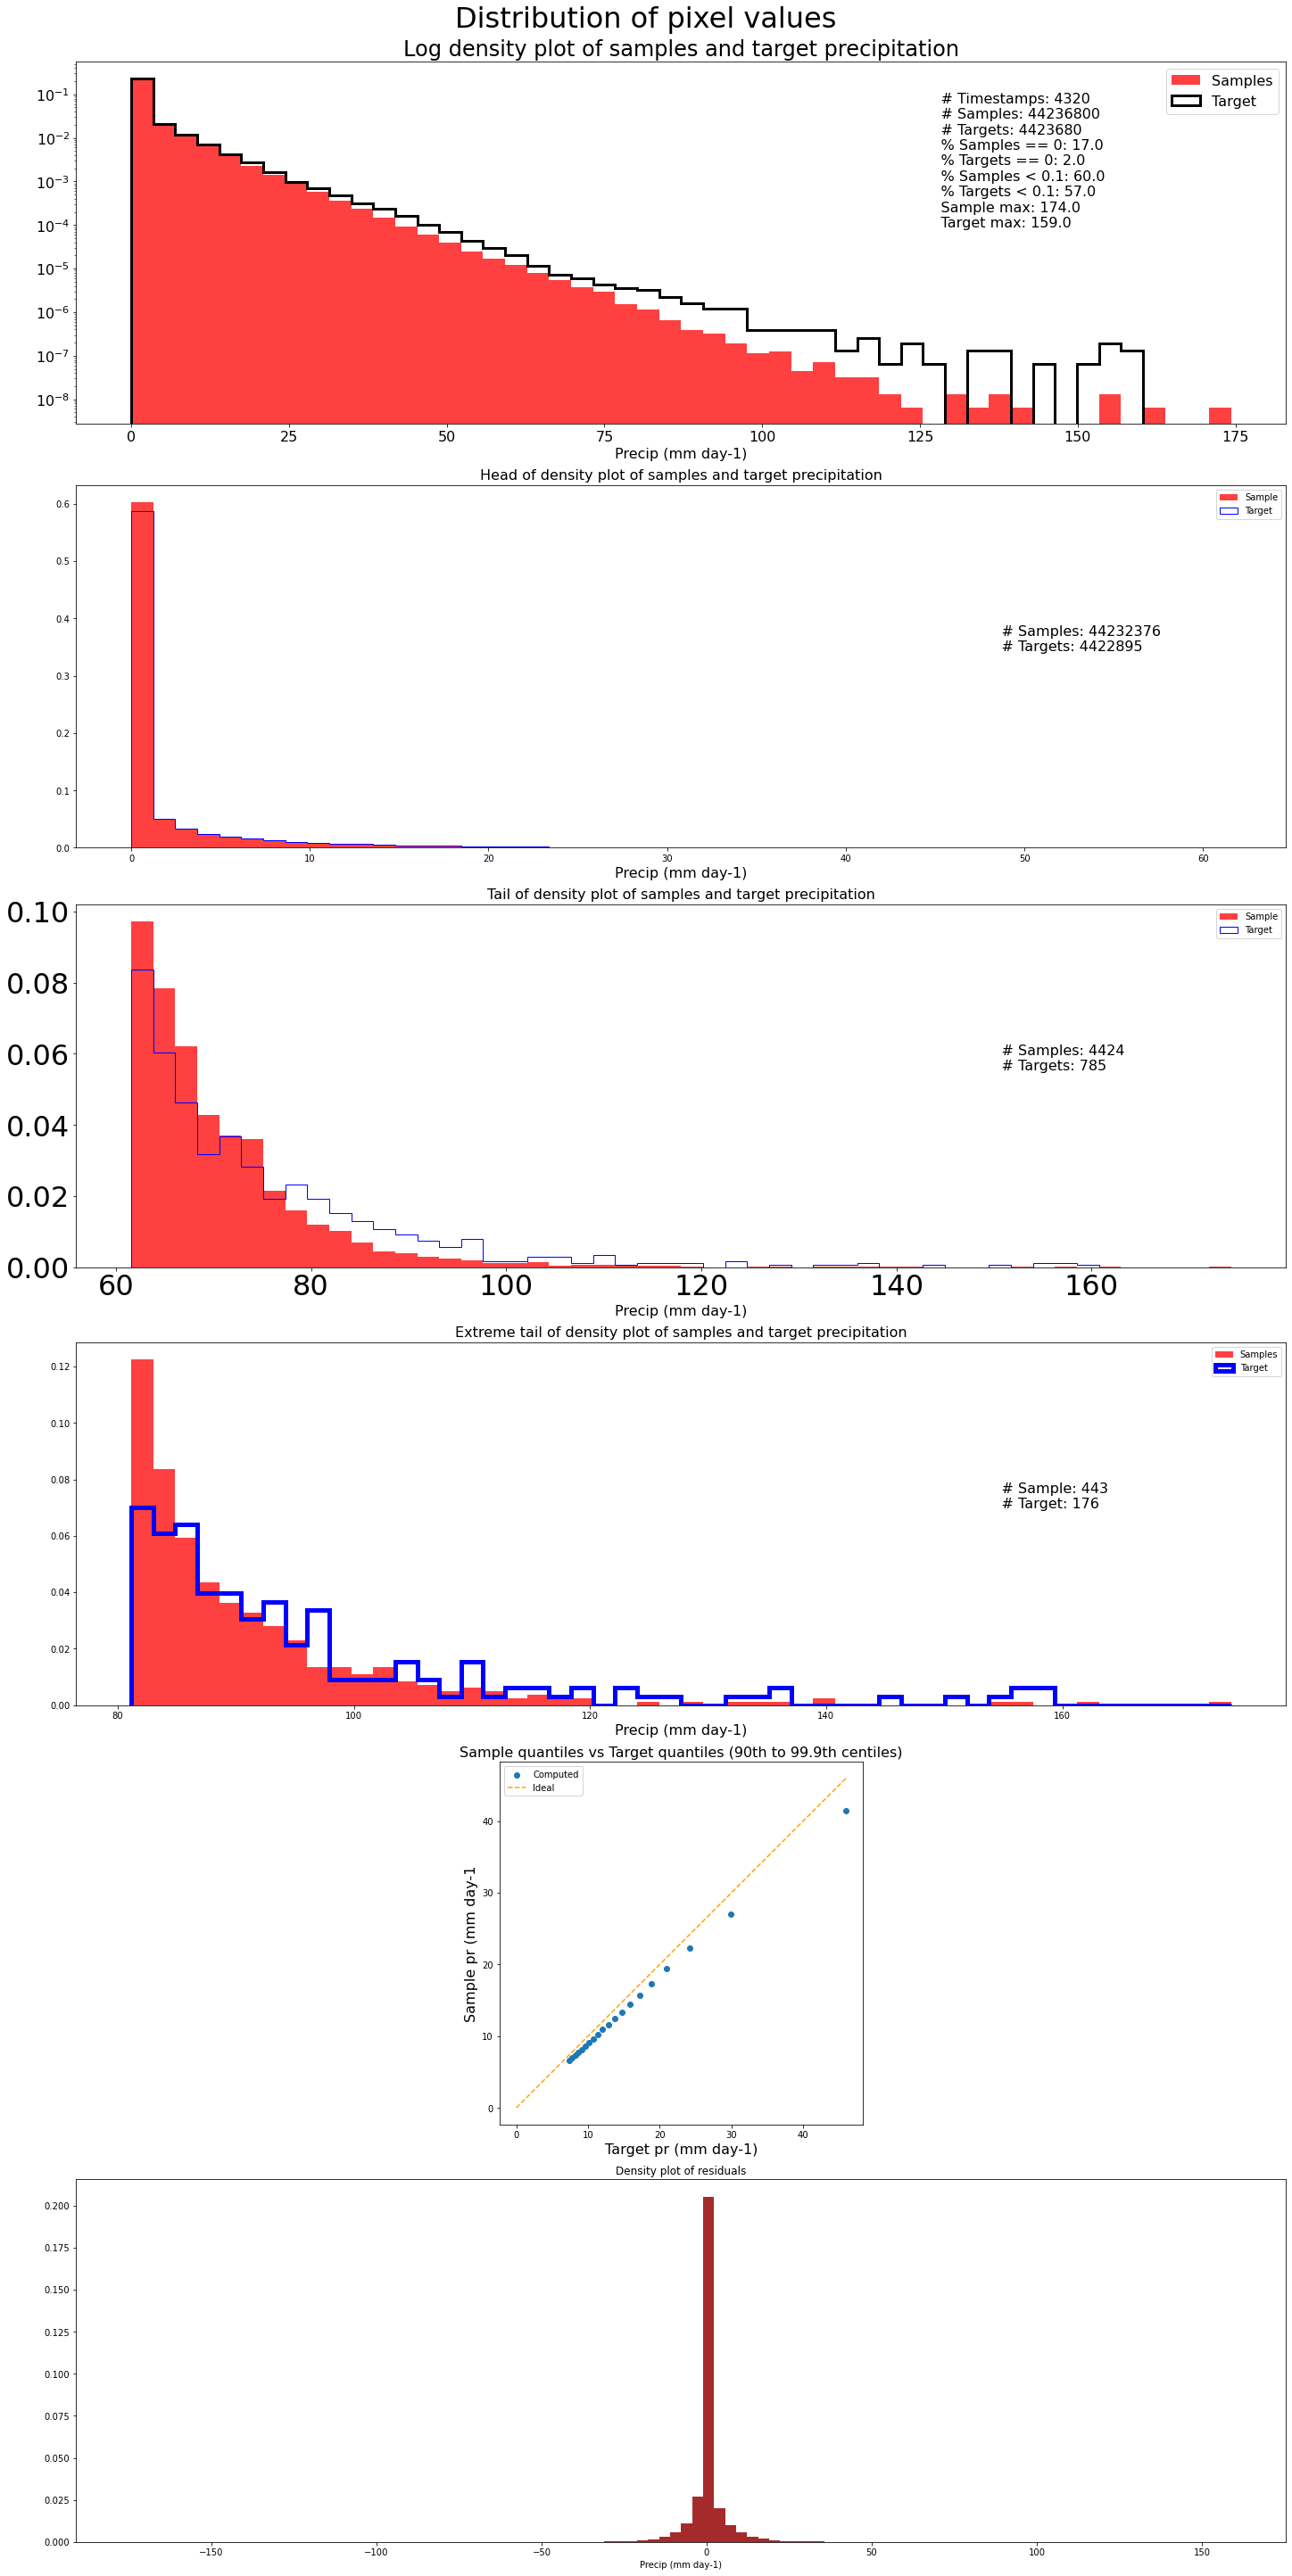

In [11]:
quantiles = np.linspace(0.9,0.999,20)
target_quantiles = target_pr.quantile(quantiles)
pred_quantiles = pred_pr.chunk(dict(sample_id=-1)).quantile(quantiles)

# distribution_figure(target_pr, pred_pr, target_quantiles, pred_quantiles, 40, 80, "Distribution of pixel values")
distribution_figure(target_pr, pred_pr, target_quantiles, pred_quantiles, pred_pr.chunk(dict(sample_id=-1)).quantile(0.9999), pred_pr.chunk(dict(sample_id=-1)).quantile(0.99999), "Distribution of pixel values")

### Summed over space

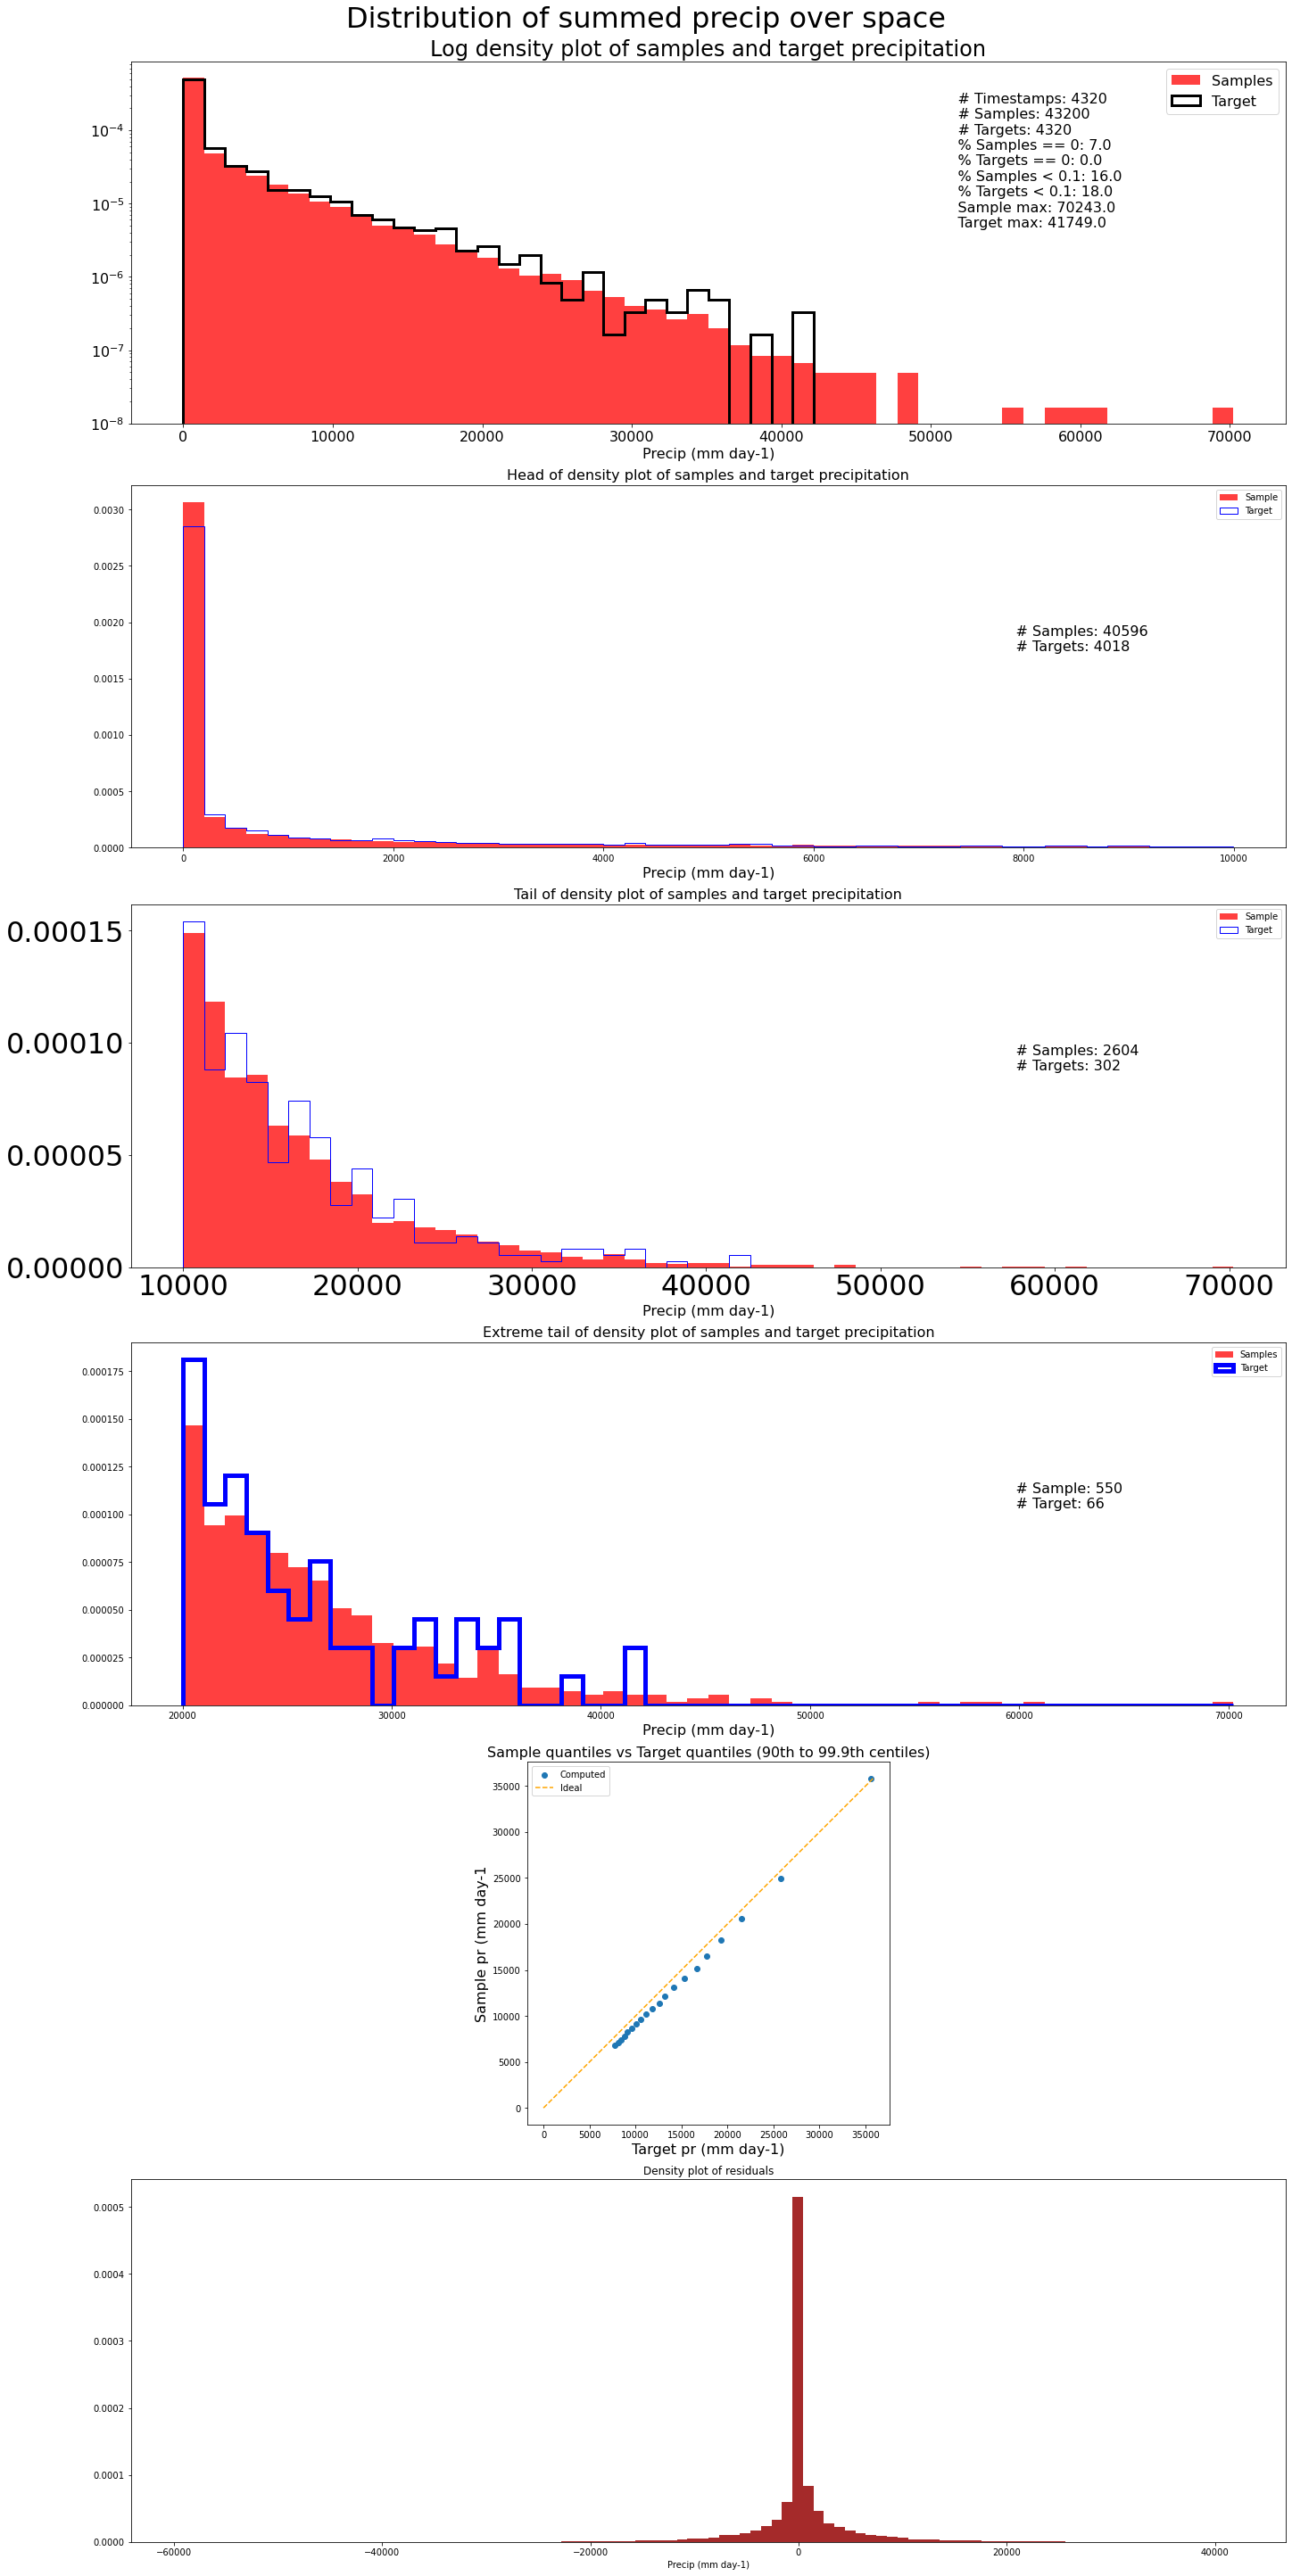

In [12]:
quantiles = np.linspace(0.9,0.999,20)
total_target_quantiles = total_target_pr.quantile(quantiles)
total_pred_quantiles = total_pred_pr.chunk(dict(sample_id=-1)).quantile(quantiles)

distribution_figure(total_target_pr, total_pred_pr, total_target_quantiles, total_pred_quantiles, 1e4, 2e4, "Distribution of summed precip over space")

## Means

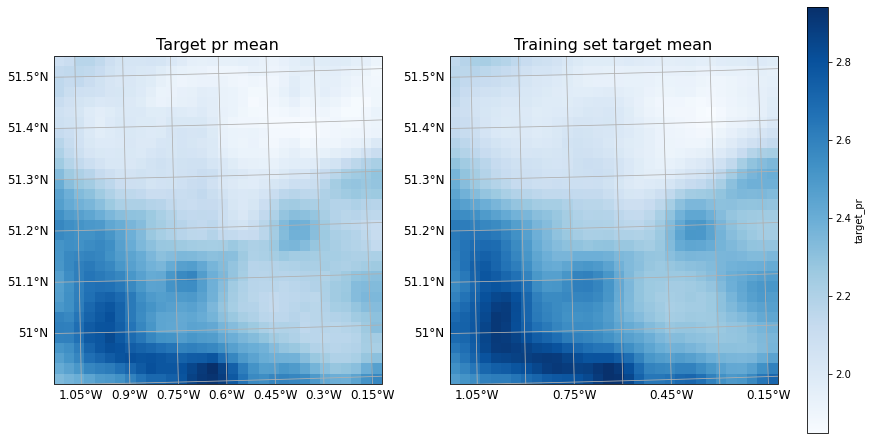

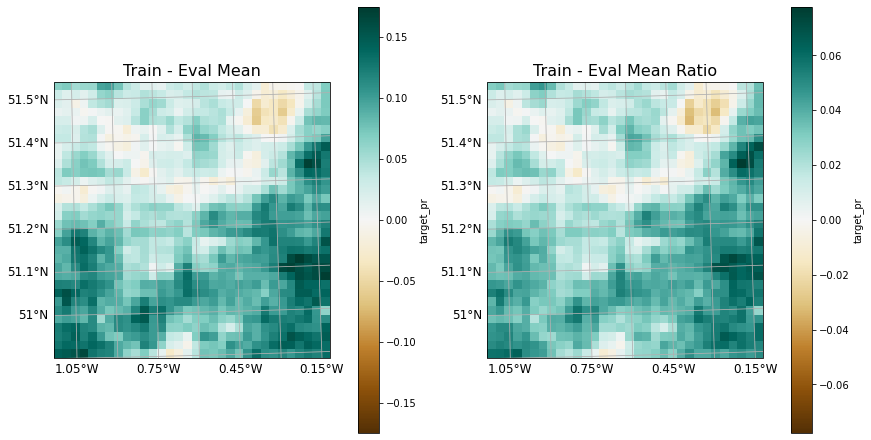

In [73]:
fig, axd = plt.subplot_mosaic([["Target", "Train Target"]], figsize=(12, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

target_mean = merged_ds['target_pr'].mean(dim="time")
train_target_mean = train_ds['target_pr'].mean(dim="time")

vmin = min([da.min().values for da in [train_target_mean, target_mean]])
vmax = max([da.max().values for da in [train_target_mean, target_mean]])

ax = axd["Target"]
# target_mean.plot(ax=ax, vmax=vmax, vmin=vmin, cmap="Blues")
# ax.set_title("Target pr mean")
# ax.coastlines()
plot_pr(target_mean, ax, title="Target pr mean", norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), add_colorbar=False)

ax = axd["Train Target"]
plot_pr(train_target_mean, ax, title="Training set target mean", norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), add_colorbar=True)
# train_target_mean.plot(ax=ax, vmax=vmax, vmin=vmin, cmap="Blues")
# ax.set_title("Training set target mean")
# ax.coastlines()

plt.show()

fig, axd = plt.subplot_mosaic([["Train - Eval Mean", "Train - Eval Mean Ratio"]], figsize=(12, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

ax = axd["Train - Eval Mean"]
# (train_target_mean - target_mean).plot(ax=ax, cmap='BrBG', center=0)
# ax.set_title("Train - Eval Mean")
# ax.coastlines()
plot_pr((train_target_mean - target_mean), ax, title="Train - Eval Mean", norm=None, add_colorbar=True, cmap='BrBG', center=0)

ax = axd["Train - Eval Mean Ratio"]
# ((train_target_mean - target_mean)/train_target_mean).plot(ax=ax, cmap='BrBG', center=0)
# ax.set_title("Train - Eval Mean Ratio")
# ax.coastlines()
plot_pr(((train_target_mean - target_mean)/train_target_mean), ax, title="Train - Eval Mean Ratio", norm=None, add_colorbar=True, cmap='BrBG', center=0)

plt.show()

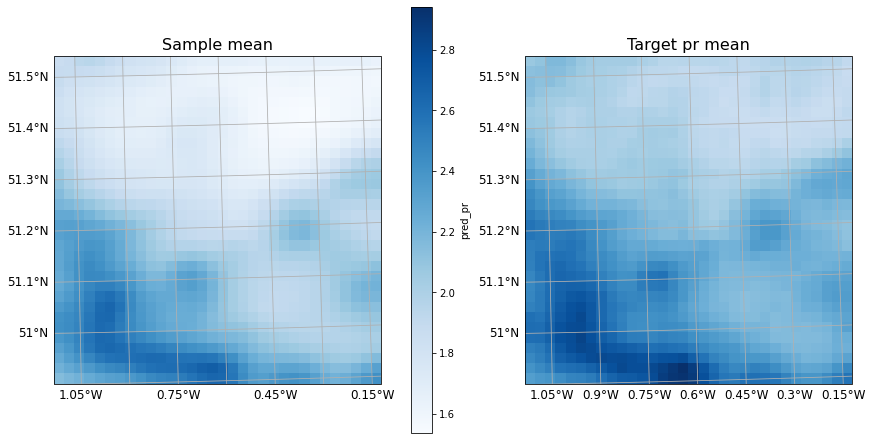

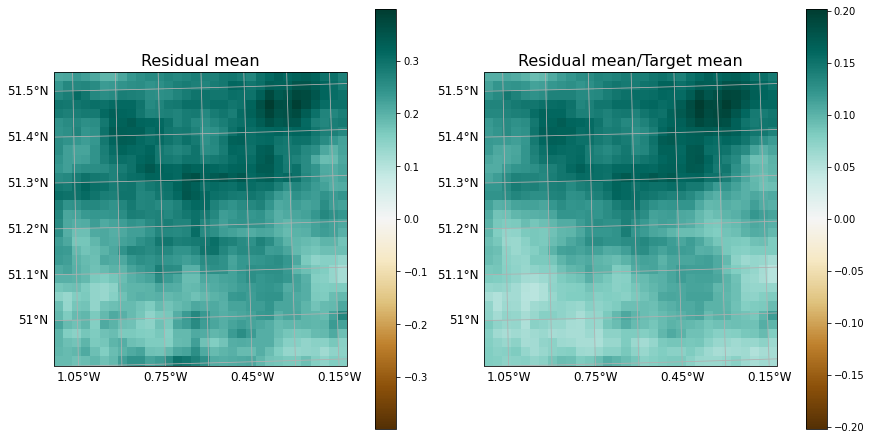

In [83]:
fig, axd = plt.subplot_mosaic([["Sample", "Target"]], figsize=(12, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

sample_mean = merged_ds['pred_pr'].mean(dim=["sample_id", "time"])
target_mean = merged_ds['target_pr'].mean(dim="time")
residuals = merged_ds['target_pr'] - merged_ds['pred_pr']
residual_mean = residuals.mean(dim=["sample_id", "time"])

vmin = min([da.min().values for da in [sample_mean, target_mean]])
vmax = max([da.max().values for da in [sample_mean, target_mean]])

ax = axd["Sample"]
# sample_mean.plot(ax=ax, vmax=vmax, vmin=vmin, cmap="Blues")
# ax.set_title("Sample mean")
# ax.coastlines()
plot_pr(sample_mean, ax, title="Sample mean", norm=None, vmin=vmin, vmax=vmax, add_colorbar=True)

ax = axd["Target"]
# target_mean.plot(ax=ax, vmax=vmax, vmin=vmin, cmap="Blues")
# ax.set_title("Target pr mean")
# ax.coastlines()
plot_pr(target_mean, ax, title="Target pr mean", norm=None, vmin=vmin, vmax=vmax, add_colorbar=False)

plt.show()

fig, axd = plt.subplot_mosaic([["Residual", "Ratio"]], figsize=(12, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

ax = axd["Residual"]
# (residual_mean).plot(ax=ax, cmap='BrBG', center=0)
# ax.set_title("Residual mean")
# ax.coastlines()
plot_pr(residual_mean, ax, title="Residual mean", norm=None, cmap="BrBG", center=0, add_colorbar=True)

ax = axd["Ratio"]
# (residual_mean/target_mean).plot(ax=ax, cmap='BrBG', center=0)
# ax.set_title("Residual mean/Target mean")
# ax.coastlines()
plot_pr((residual_mean/target_mean), ax, title="Residual mean/Target mean", norm=None, cmap="BrBG", center=0, add_colorbar=True)

plt.show()


## Standard deviation

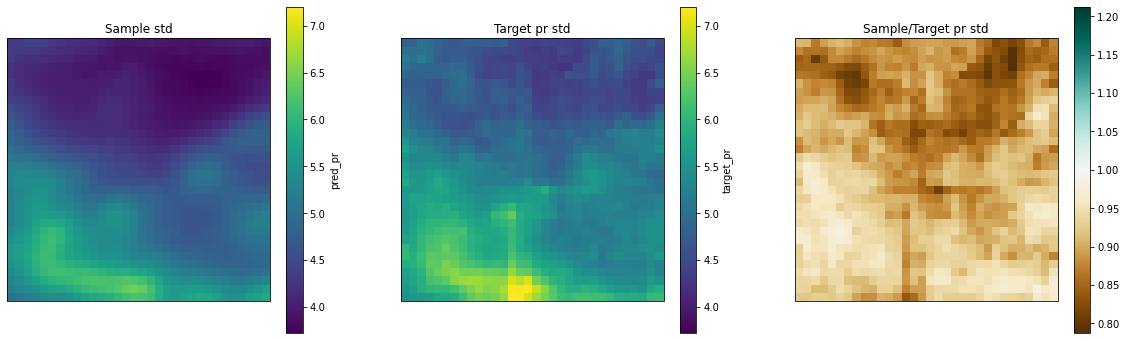

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw=dict(projection=cp_model_rotated_pole))

sample_std = merged_ds['pred_pr'].std(dim=["sample_id", "time"])
target_std = merged_ds['target_pr'].std(dim="time")

vmin = min([da.min().values for da in [sample_std, target_std]])
vmax = max([da.max().values for da in [sample_std, target_std]])

ax = axs[0]
sample_std.plot(ax=ax, vmax=vmax, vmin=vmin)
ax.set_title("Sample std")
ax.coastlines()

ax = axs[1]
target_std.plot(ax=ax, vmax=vmax, vmin=vmin)
ax.set_title("Target pr std")
ax.coastlines()

ax = axs[2]
(sample_std/target_std).plot(ax=ax, cmap="BrBG", center=1)
ax.set_title("Sample/Target pr std")
ax.coastlines()

plt.show()

## Scatter

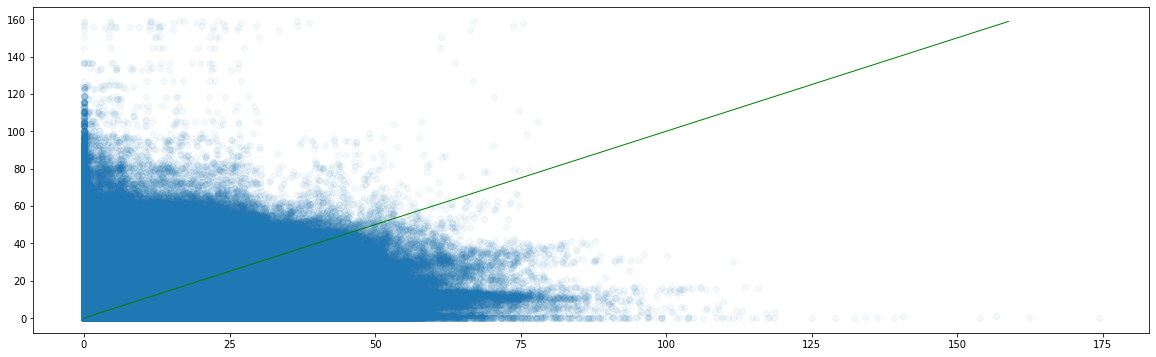

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(20, 6))

tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())


ax = axs

ax.scatter(x=merged_ds["pred_pr"], y=merged_ds["target_pr"].values[None, :].repeat(len(merged_ds["sample_id"]), 0), alpha=0.05)
ax.plot([0, tr], [0, tr], linewidth=1, color='green')


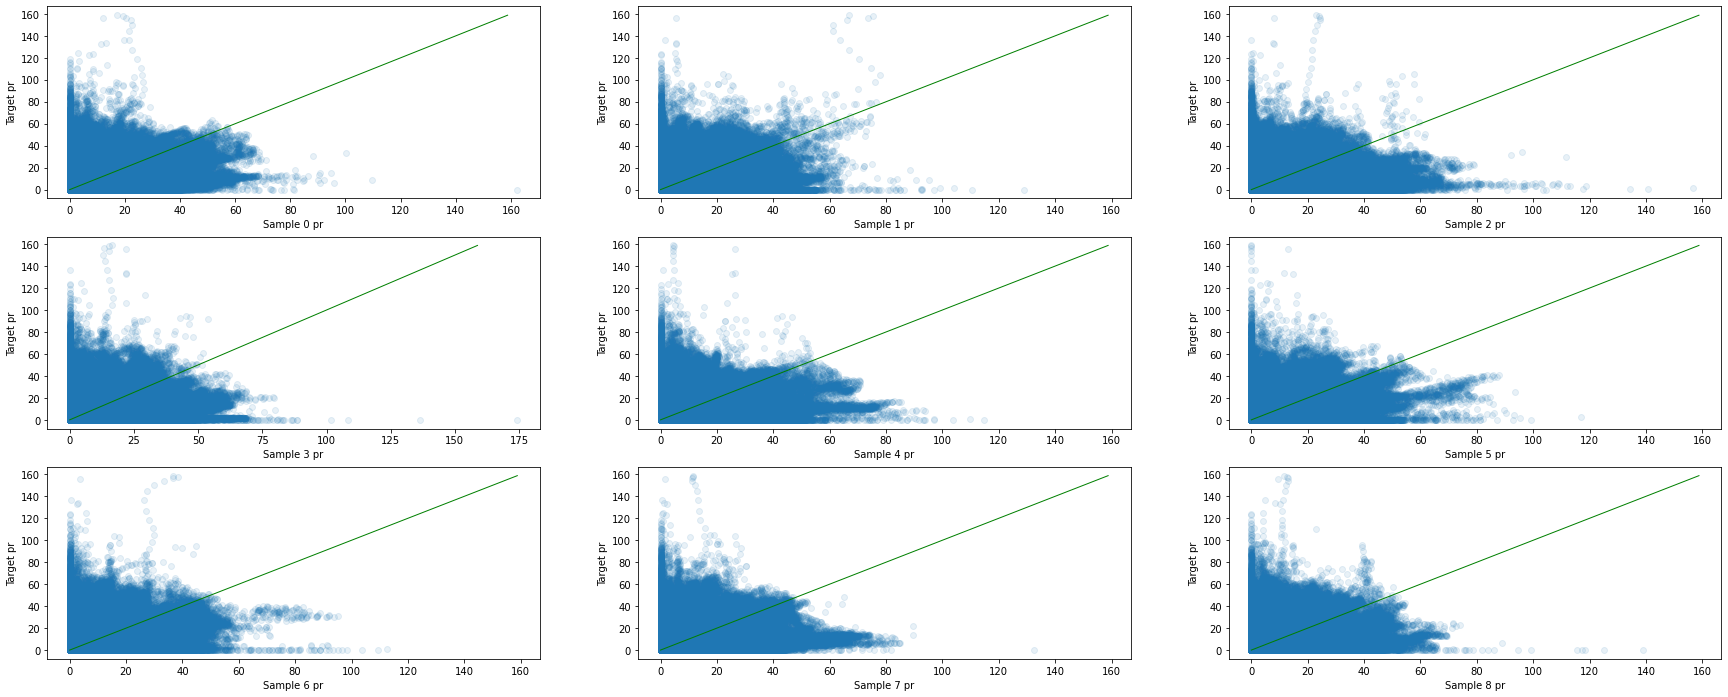

In [16]:
sample_ids = np.arange(9).reshape(3, 3)

fig, axs = plt.subplots(sample_ids.shape[0], sample_ids.shape[1], figsize=(30, 12))

tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())

for i, sample_id in enumerate(sample_ids.flatten()):
    ax = axs[i//3][i%3]

    ax.scatter(x=merged_ds["pred_pr"].sel(sample_id=sample_id), y=merged_ds["target_pr"], alpha=0.1)
    ax.plot([0, tr], [0, tr], linewidth=1, color='green')
    ax.set_xlabel(f"Sample {sample_id} pr")
    ax.set_ylabel(f"Target pr")
    
plt.show()

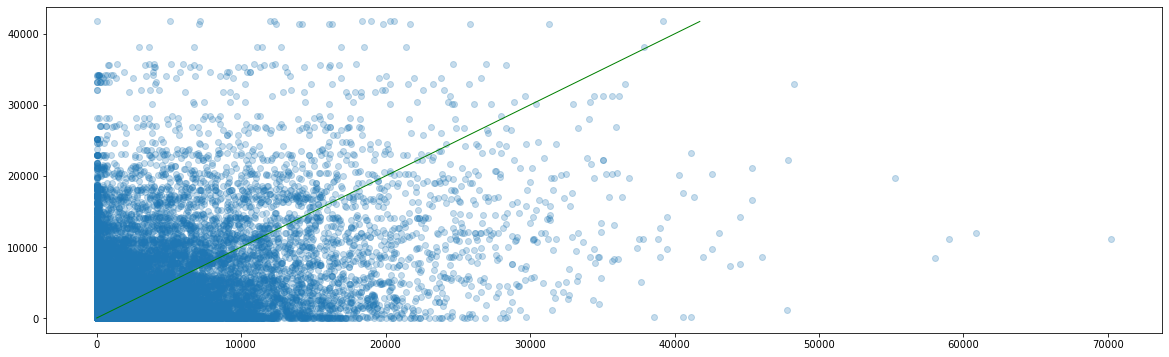

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(20, 6))

tr = min(total_pred_pr.max(), total_target_pr.max())

ax = axs

ax.scatter(x=total_pred_pr, y=total_target_pr.values[None, :].repeat(len(total_pred_pr["sample_id"]), 0), alpha=0.25)
ax.plot([0, tr], [0, tr], linewidth=1, color='green')

plt.show()

## PSD

In [18]:
import pysteps

Pysteps configuration file found at: /home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/pysteps/pystepsrc



In [19]:
pysteps.utils.spectral.rapsd(merged_ds["target_pr"].isel(time=0).values)

array([2.0530963e-05, 1.7348819e-05, 1.7565268e-05, 1.9026818e-05,
       1.9924253e-05, 2.3115324e-05, 2.3287505e-05, 2.8441271e-05,
       2.2854963e-05, 1.8264625e-05, 1.7375834e-05, 1.6957631e-05,
       1.5953343e-05, 1.4348093e-05, 2.0715714e-05, 2.1320166e-05,
       2.4216908e-05], dtype=float32)